
# Лабораторная работа №3. Однофакторный дисперсионный анализ

> Вариант № 1

**Распределения**:

$X_1$ ~ N (объём выборки $n_1$ = 100)

$X_2$ ~ R (объём выборки $n_2$ = 150)

$X_3$ ~ N (объём выборки $n_3$ = 200)

In [2]:
%matplotlib inline
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

# Немного магии для того, чтобы рисунки стали больше
import pylab
pylab.rcParams['figure.figsize'] = (24.0, 16.0)
plt.rcParams.update({'font.size': 22})

# Вспомогательные классы и функции, определённые тут же (см. репозиторий)
# https://github.com/BobNobrain/matstat-labs/tree/master/s
from s import Sample, PooledSample, BartlettHyp, OneWayAnovaHyp, LinearContrastHyp
from s.utils import table, printf



## 1. Исходные данные

In [3]:
X1 = stats.norm(1, 2)
X2 = stats.uniform(0, 2)
X3 = stats.norm(1, 3)

n1 = 100
n2 = 150
n3 = 200


print('Характеристики наблюдаемых случайных величин:')
table(
    ['СВ', 'Распределение', 'Параметры', '$m_i$', '$\\sigma_i^2$', '$n_i$'],
    [
        ['X1', 'N', '$m=1, \\sigma=2$', X1.mean(), X1.var(), n1],
        ['X2', 'R', '$m=1, \\sigma=0.333$', X2.mean(), X2.var(), n2],
        ['X3', 'N', '$m=1, \\sigma=3$', X3.mean(), X3.var(), n3]
    ]
)
printf('Количество случайных величин $k={}$', 3)
    

Характеристики наблюдаемых случайных величин:


СВ,Распределение,Параметры,$m_i$,$\sigma_i^2$,$n_i$
X1,N,"$m=1, \sigma=2$",1.0,4.0,100
X2,R,"$m=1, \sigma=0.333$",1.0,0.3333333333333333,150
X3,N,"$m=1, \sigma=3$",1.0,9.0,200


In [4]:
x1 = Sample.from_distribution("x1", X1, count=n1)
x2 = Sample.from_distribution("x2", X2, count=n2)
x3 = Sample.from_distribution("x3", X3, count=n3)

x_pooled = PooledSample("Pooled", x1, x2, x3)

print('Выборочные характеристики:')
table(
    ['СВ', 'Среднее $\\overline{x_i}$', '$s^2_i$', '$s_i$'],
    [
        [
            s._name,
            round(s.mean(), 4),
            round(s.s() ** 2, 4),
            round(s.s(), 4)
        ] for s in [x1, x2, x3, x_pooled]
    ]
)

Выборочные характеристики:


СВ,Среднее $\overline{x_i}$,$s^2_i$,$s_i$
x1,0.8185,4.1775,2.0439
x2,0.966,0.2958,0.5439
x3,0.7891,9.2133,3.0353
Pooled,0.8546,5.109,2.2603


## 2. Визуальное представление выборок

Диаграммы *Box-and-Whisker*:

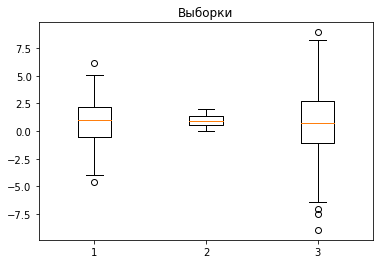

In [5]:
fig, ax = plt.subplots()

ax.boxplot([x1.data(), x2.data(), x3.data()])
ax.set_title('Выборки')

plt.show()

## 3. Проверка условия применимости дисперсионного анализа

Статистическая гипотеза $H_0: \sigma_1^2 = \sigma_2^2 = \sigma_3^2$

In [6]:
print('Критерий Бартлетта')

alpha = 0.05

H0 = BartlettHyp(x_pooled)
criterion_value, interval, p_value, result = H0.full_test(x_pooled, alpha)
decision="H0"
if result:
    decision = 'H0' 
else:
    decision = 'H1'

answer=""
if  decision=='H0':
    answer="Есть ошибка"
else:
    answer="Ошибки нет"
    
table(
    [
        'Выборочное значение статистики критерия',
        'p-value',
        'Статистическое решение при $\\alpha={}$'.format(alpha),
        'Ошибка статистического решения'
    ],
    [[
        round(criterion_value, 4),
        round(p_value, 4),
        decision,
        answer
    
    ]]
)

Критерий Бартлетта


Выборочное значение статистики критерия,p-value,Статистическое решение при $\alpha=0.05$,Ошибка статистического решения
327.4508,0.0,H1,Ошибки нет


## 4. Однофакторный дисперсионный анализ

In [7]:
print('Таблица дисперсионного анализа')

# http://datalearning.ru/index.php/textbook?cid=1&mid=5&topic=2, таблица 6.4
table(
    ['Источник вариации', 'Показатель вариации', 'Число степеней свободы', 'Несмещённая оценка'],
    [
        ['Группировочный признак', round(x_pooled.between_group_var(),4), '2', round(250*x_pooled.between_group_var(),4)],
        ['Остаточные признаки', round(x_pooled.within_group_var(),4), '447', round(450.0/447.0*x_pooled.within_group_var(),4)],
        ['Все признаки', round(x_pooled.var(),4), '449', round(450.0/449.0*x_pooled.var(),4)]
    ]
)

eta2 = x_pooled.eta_squared()
printf('Эмпирический коэффициент детерминации $\\eta^2 = {}$', round(eta2, 4))
printf('Эмпирическое корреляционное отношение $\\eta = {}$', round(np.sqrt(eta2), 4))

Таблица дисперсионного анализа


Источник вариации,Показатель вариации,Число степеней свободы,Несмещённая оценка
Группировочный признак,0.0063,2,1.5842
Остаточные признаки,5.0913,447,5.1255
Все признаки,5.0977,449,5.109


Статистическая гипотеза $H_0: m_1 = m_2 = m_3$

In [8]:
alpha = 0.05

anova = OneWayAnovaHyp(x_pooled)
criterion_value, (crit_left, crit_right), p_value, result = anova.full_test(x_pooled, alpha)

decision="H0"
if result:
    decision = 'H0' 
else:
    decision = 'H1'

answer=""
if  decision=='H0':
    answer="Есть ошибка"
else:
    answer="Ошибки нет"
    

table(
    [
        'Выборочное значение статистики критерия',
        'p-value',
        'Статистическое решение при $\\alpha={}$'.format(alpha),
        'Ошибка статистического решения'
    ],
    [[
        round(criterion_value, 4),
        round(p_value, 4),
        decision,
        answer
    ]]
)


Выборочное значение статистики критерия,p-value,Статистическое решение при $\alpha=0.05$,Ошибка статистического решения
0.2782,0.7573,H0,Есть ошибка


## 5. Метод линейных контрастов

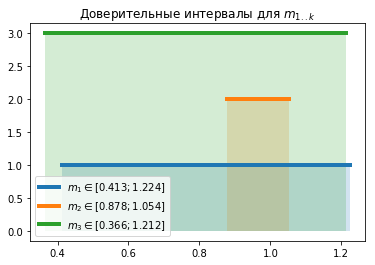

Гипотеза,Выборочное значение статистики критерия,p-value,Статистическое решение при $\alpha=0.05$,Ошибка статистического решения
$m_1=m_2$,-0.1475,0.0,H1,Есть ошибка
$m_2=m_3$,0.177,0.3243,H1,Есть ошибка
$m_1=m_3$,0.0295,0.0581,H0,Ошибки нет


In [9]:
alpha = 0.05

def m_interval(sample):
    n = sample.n()
    delta = stats.t(n - 1).ppf(1 - alpha / 2) * sample.s() / np.sqrt(n)
    mean = sample.mean()
    return mean - delta, mean + delta

def check_m(c1,c2,c3):
    H0 = LinearContrastHyp(x_pooled)
    c, (k1, k2), p_value, result = H0.full_test([c1, c2, c3], alpha=alpha)
    answer="Есть ошибка"
    decision="H1"
    if result:
        decision="H0"
    if (decision=="H0"):
        answer="Ошибки нет"
        
    return decision,p_value,c,answer


fig, ax = plt.subplots()
ax.set_title('Доверительные интервалы для $m_{1..k}$')

samples = [x1, x2, x3]
for i in range(len(samples)):
    l, r = m_interval(samples[i])
    domain = [l, r]
    values = [i + 1, i + 1]
    ax.plot(
        domain,
        values,
        label='$m_{} \\in [{}; {}]$'.format(i + 1, round(l, 3), round(r, 3)),
        linewidth=4
    )
    ax.fill_between(domain, 0, values, alpha=.2)

plt.legend()
plt.show()


decision1, p_value1, c1, answer1 = check_m(1,-1,0)
decision2, p_value2, c2, answer2 = check_m(0,1,-1)
decision3, p_value3, c3, answer3 = check_m(1,0,-1)

table(
    [
        'Гипотеза',
        'Выборочное значение статистики критерия',
        'p-value',
        'Статистическое решение при $\\alpha={}$'.format(alpha),
        'Ошибка статистического решения'
    ],
    [

        ['$m_1=m_2$', round(c1, 4), round(p_value1, 4), decision1, answer1],
        ['$m_2=m_3$', round(c2, 4), round(p_value2, 4), decision2, answer2],
        ['$m_1=m_3$', round(c3, 4), round(p_value3, 4), decision3, answer3]
    ]
)